In [2]:
#@Demo3_LinearElasticity
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time
from ufl import replace

def plot_compact(u, t, stepcounter, QQ, pl, ax, label = "Velocity", clear = True): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl);
    if clear:
      clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm", label=label); plt.title("%s at t=%f" % (label, t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    #plt.subplot(1, 2, 2);
    #if t == 0.: Q.mesh(); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();display(pl);
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G);plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(Q.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout();dpl = display(pl, display_id="test");
  return (pl, ax)


E: Package 'python-software-properties' has no installation candidate
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]


In [0]:
#@title
# -*- coding: utf-8 -*-
# Copyright (C) 2008-2012 Joachim B. Haga and Fredrik Valdmanis
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

import os

import dolfin
import dolfin.cpp as cpp
import ufl
import numpy as np

__all__ = ['plot']

_meshfunction_types = (cpp.mesh.MeshFunctionBool,
                       cpp.mesh.MeshFunctionInt,
                       cpp.mesh.MeshFunctionDouble,
                       cpp.mesh.MeshFunctionSizet)
_matplotlib_plottable_types = (cpp.function.Function,
                               cpp.function.Expression, cpp.mesh.Mesh,
                               cpp.fem.DirichletBC) + _meshfunction_types
_x3dom_plottable_types = (cpp.function.Function, cpp.mesh.Mesh)
_all_plottable_types = tuple(set.union(set(_matplotlib_plottable_types),
                                       set(_x3dom_plottable_types)))


def _has_matplotlib():
    try:
        import matplotlib  # noqa
    except ImportError:
        return False
    return True


def mesh2triang(mesh):
    import matplotlib.tri as tri
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def mplot_mesh(ax, mesh, **kwargs):
    tdim = mesh.topology().dim()
    gdim = mesh.geometry().dim()
    if gdim == 2 and tdim == 2:
        color = kwargs.pop("color", '#808080')
        return ax.triplot(mesh2triang(mesh), color=color, **kwargs)
    elif gdim == 3 and tdim == 3:
        bmesh = cpp.mesh.BoundaryMesh(mesh, "exterior", order=False)
        mplot_mesh(ax, bmesh, **kwargs)
    elif gdim == 3 and tdim == 2:
        xy = mesh.coordinates()
        return ax.plot_trisurf(*[xy[:, i] for i in range(gdim)],
                               triangles=mesh.cells(), **kwargs)
    elif tdim == 1:
        x = [mesh.coordinates()[:, i] for i in range(gdim)]
        if gdim == 1:
            x.append(np.zeros_like(x[0]))
            ax.set_yticks([])
        marker = kwargs.pop('marker', 'o')
        return ax.plot(*x, marker=marker, **kwargs)
    else:
        assert False, "this code should not be reached"


# TODO: This is duplicated somewhere else
def create_cg1_function_space(mesh, sh):
    r = len(sh)
    if r == 0:
        V = dolfin.FunctionSpace(mesh, "CG", 1)
    elif r == 1:
        V = dolfin.VectorFunctionSpace(mesh, "CG", 1, dim=sh[0])
    else:
        V = dolfin.TensorFunctionSpace(mesh, "CG", 1, shape=sh)
    return V


def mplot_expression(ax, f, mesh, **kwargs):
    # TODO: Can probably avoid creating the function space here by
    # restructuring mplot_function a bit so it can handle Expression
    # natively
    V = create_cg1_function_space(mesh, f.value_shape)
    g = dolfin.interpolate(f, V)
    return mplot_function(ax, g, **kwargs)


def mplot_function(ax, f, **kwargs):
    mesh = f.function_space().mesh()
    gdim = mesh.geometry().dim()
    tdim = mesh.topology().dim()

    # Extract the function vector in a way that also works for
    # subfunctions
    try:
        fvec = f.vector()
    except RuntimeError:
        fspace = f.function_space()
        try:
            fspace = fspace.collapse()
        except RuntimeError:
            return
        fvec = dolfin.interpolate(f, fspace).vector()

    if fvec.size() == mesh.num_cells():
        # DG0 cellwise function
        C = fvec.get_local()  # NB! Assuming here dof ordering matching cell numbering
        if gdim == 2 and tdim == 2:
            return ax.tripcolor(mesh2triang(mesh), C, **kwargs)
        elif gdim == 3 and tdim == 2:  # surface in 3d
            # FIXME: Not tested, probably broken
            xy = mesh.coordinates()
            shade = kwargs.pop("shade", True)
            return ax.plot_trisurf(mesh2triang(mesh), xy[:, 2], C, shade=shade,
                                   **kwargs)
        elif gdim == 1 and tdim == 1:
            x = mesh.coordinates()[:, 0]
            nv = len(x)
            # Insert duplicate points to get piecewise constant plot
            xp = np.zeros(2 * nv - 2)
            xp[0] = x[0]
            xp[-1] = x[-1]
            xp[1:2 * nv - 3:2] = x[1:-1]
            xp[2:2 * nv - 2:2] = x[1:-1]
            Cp = np.zeros(len(xp))
            Cp[0:len(Cp) - 1:2] = C
            Cp[1:len(Cp):2] = C
            return ax.plot(xp, Cp, *kwargs)
        # elif tdim == 1:  # FIXME: Plot embedded line
        else:
            raise AttributeError('Matplotlib plotting backend only supports 2D mesh for scalar functions.')

    elif f.value_rank() == 0:
        # Scalar function, interpolated to vertices
        # TODO: Handle DG1?
        C = f.compute_vertex_values(mesh)
        if gdim == 2 and tdim == 2:
            mode = kwargs.pop("mode", "contourf")
            if mode == "contourf":
                levels = kwargs.pop("levels", 40)
                return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
            elif mode == "color":
                shading = kwargs.pop("shading", "gouraud")
                return ax.tripcolor(mesh2triang(mesh), C, shading=shading,
                                    **kwargs)
            elif mode == "warp":
                from matplotlib import cm
                cmap = kwargs.pop("cmap", cm.jet)
                linewidths = kwargs.pop("linewidths", 0)
                return ax.plot_trisurf(mesh2triang(mesh), C, cmap=cmap,
                                       linewidths=linewidths, **kwargs)
            elif mode == "wireframe":
                return ax.triplot(mesh2triang(mesh), **kwargs)
            elif mode == "contour":
                return ax.tricontour(mesh2triang(mesh), C, **kwargs)
        elif gdim == 3 and tdim == 2:  # surface in 3d
            # FIXME: Not tested
            from matplotlib import cm
            cmap = kwargs.pop("cmap", cm.jet)
            return ax.plot_trisurf(mesh2triang(mesh), C, cmap=cmap, **kwargs)
        elif gdim == 3 and tdim == 3:
            # Volume
            # TODO: Isosurfaces?
            # Vertex point cloud
            X = [mesh.coordinates()[:, i] for i in range(gdim)]
            return ax.scatter(*X, c=C, **kwargs)
        elif gdim == 1 and tdim == 1:
            x = mesh.coordinates()[:, 0]
            ax.set_aspect('auto')

            p = ax.plot(x, C, **kwargs)

            # Setting limits for Line2D objects
            # Must be done after generating plot to avoid ignoring function
            # range if no vmin/vmax are supplied
            vmin = kwargs.pop("vmin", None)
            vmax = kwargs.pop("vmax", None)
            ax.set_ylim([vmin, vmax])

            return p
        # elif tdim == 1: # FIXME: Plot embedded line
        else:
            raise AttributeError('Matplotlib plotting backend only supports 2D mesh for scalar functions.')

    elif f.value_rank() == 1:
        # Vector function, interpolated to vertices
        w0 = f.compute_vertex_values(mesh)
        nv = mesh.num_vertices()
        if len(w0) != gdim * nv:
            raise AttributeError('Vector length must match geometric dimension.')
        X = mesh.coordinates()
        X = [X[:, i] for i in range(gdim)]
        U = [w0[i * nv: (i + 1) * nv] for i in range(gdim)]

        # Compute magnitude
        C = U[0]**2
        for i in range(1, gdim):
            C += U[i]**2
        C = np.sqrt(C)

        mode = kwargs.pop("mode", "glyphs")
        if mode == "glyphs":
            args = X + U + [C]
            if gdim == 3:
                length = kwargs.pop("length", 0.1)
                return ax.quiver(*args, length=length, **kwargs)
            else:
                return ax.quiver(*args, **kwargs)
        elif mode == "displacement":
            Xdef = [X[i] + U[i] for i in range(gdim)]
            import matplotlib.tri as tri
            if gdim == 2 and tdim == 2:
                # FIXME: Not tested
                triang = tri.Triangulation(Xdef[0], Xdef[1], mesh.cells())
                shading = kwargs.pop("shading", "flat")
                return ax.tripcolor(triang, C, shading=shading, **kwargs)
            else:
                # Return gracefully to make regression test pass without vtk
                cpp.warning('Matplotlib plotting backend does not support '
                            'displacement for %d in %d. Continuing without '
                            'plotting...' % (tdim, gdim))
                return


def mplot_meshfunction(ax, obj, **kwargs):
    mesh = obj.mesh()
    tdim = mesh.topology().dim()
    d = obj.dim()
    if tdim == 2 and d == 2:
        C = obj.array()
        triang = mesh2triang(mesh)
        assert not kwargs.pop("facecolors", None), "Not expecting 'facecolors' in kwargs"
        return ax.tripcolor(triang, facecolors=C, **kwargs)
    else:
        # Return gracefully to make regression test pass without vtk
        cpp.warning('Matplotlib plotting backend does not support mesh '
                    'function of dim %d. Continuing without plotting...' % d)
        return


def mplot_dirichletbc(ax, obj, **kwargs):
    raise AttributeError("Matplotlib plotting backend doesn't handle DirichletBC.")


def _plot_matplotlib(obj, mesh, kwargs):
    if not isinstance(obj, _matplotlib_plottable_types):
        print("Don't know how to plot type %s." % type(obj))
        return

    # Plotting is not working with all ufl cells
    if mesh.ufl_cell().cellname() not in ['interval', 'triangle', 'tetrahedron']:
        raise AttributeError(("Matplotlib plotting backend doesn't handle %s mesh.\n"
                              "Possible options are saving the output to XDMF file "
                              "or using 'x3dom' backend.") % mesh.ufl_cell().cellname())

    # Avoid importing pyplot until used
    try:
        import matplotlib.pyplot as plt
    except Exception:
        cpp.warning("matplotlib.pyplot not available, cannot plot.")
        return

    gdim = mesh.geometry().dim()
    if gdim == 3 or kwargs.get("mode") in ("warp",):
        # Importing this toolkit has side effects enabling 3d support
        from mpl_toolkits.mplot3d import axes3d  # noqa
        # Enabling the 3d toolbox requires some additional arguments
        ax = plt.gca(projection='3d')
    else:
        ax = plt.gca()
        ax.set_aspect('equal')

    title = kwargs.pop("title", None)
    if title is not None:
        ax.set_title(title)

    # Translate range_min/max kwargs supported by VTKPlotter
    vmin = kwargs.pop("range_min", None)
    vmax = kwargs.pop("range_max", None)
    if vmin and "vmin" not in kwargs:
        kwargs["vmin"] = vmin
    if vmax and "vmax" not in kwargs:
        kwargs["vmax"] = vmax

    # Drop unsupported kwargs and inform user
    _unsupported_kwargs = ["rescale", "wireframe"]
    for kw in _unsupported_kwargs:
        if kwargs.pop(kw, None):
            cpp.warning("Matplotlib backend does not support '%s' kwarg yet. "
                        "Ignoring it..." % kw)

    if isinstance(obj, cpp.function.Function):
        return mplot_function(ax, obj, **kwargs)
    elif isinstance(obj, cpp.function.Expression):
        return mplot_expression(ax, obj, mesh, **kwargs)
    elif isinstance(obj, cpp.mesh.Mesh):
        return mplot_mesh(ax, obj, **kwargs)
    elif isinstance(obj, cpp.fem.DirichletBC):
        return mplot_dirichletbc(ax, obj, **kwargs)
    elif isinstance(obj, _meshfunction_types):
        return mplot_meshfunction(ax, obj, **kwargs)
    else:
        raise AttributeError('Failed to plot %s' % type(obj))


def _plot_x3dom(obj, kwargs):
    if not isinstance(obj, _x3dom_plottable_types):
        cpp.warning("Don't know how to plot type %s." % type(obj))
        return

    x3dom = dolfin.X3DOM()
    out = x3dom.html(obj)

    return out


def plot(object, *args, **kwargs):
    """
    Plot given object.

    *Arguments*
        object
            a :py:class:`Mesh <dolfin.cpp.Mesh>`, a :py:class:`MeshFunction
            <dolfin.cpp.MeshFunction>`, a :py:class:`Function
            <dolfin.functions.function.Function>`, a :py:class:`Expression`
            <dolfin.cpp.Expression>, a :py:class:`DirichletBC`
            <dolfin.cpp.DirichletBC>, a :py:class:`FiniteElement
            <ufl.FiniteElement>`.

    *Examples of usage*
        In the simplest case, to plot only e.g. a mesh, simply use

        .. code-block:: python

            mesh = UnitSquare(4, 4)
            plot(mesh)

        Use the ``title`` argument to specify title of the plot

        .. code-block:: python

            plot(mesh, tite="Finite element mesh")

        It is also possible to plot an element

        .. code-block:: python

            element = FiniteElement("BDM", tetrahedron, 3)
            plot(element)

        Vector valued functions can be visualized with an alternative mode

        .. code-block:: python

            plot(u, mode = "glyphs")

        A more advanced example

        .. code-block:: python

            plot(u,
                 wireframe = True,              # use wireframe rendering
                 interactive = False,           # do not hold plot on screen
                 scalarbar = False,             # hide the color mapping bar
                 hardcopy_prefix = "myplot",    # default plotfile name
                 scale = 2.0,                   # scale the warping/glyphs
                 title = "Fancy plot",          # set your own title
                 )

    """

    # Return if plotting is disables
    if os.environ.get("DOLFIN_NOPLOT", "0") != "0":
        return

    # Return if Matplotlib is not available
    if not _has_matplotlib():
        cpp.log.info("Matplotlib is required to plot from Python.")
        return

    # Plot element
    if isinstance(object, ufl.FiniteElementBase):
        import ffc
        return ffc.plot(object, *args, **kwargs)

    # For dolfin.function.Function, extract cpp_object
    if hasattr(object, "cpp_object"):
        object = object.cpp_object()

    # Get mesh from explicit mesh kwarg, only positional arg, or via
    # object
    mesh = kwargs.pop('mesh', None)
    if isinstance(object, cpp.mesh.Mesh):
        if mesh is not None and mesh.id() != object.id():
            raise RuntimeError("Got different mesh in plot object and keyword argument")
        mesh = object
    if mesh is None:
        if isinstance(object, cpp.function.Function):
            mesh = object.function_space().mesh()
        elif hasattr(object, "mesh"):
            mesh = object.mesh()

    # Expressions do not carry their own mesh
    if isinstance(object, cpp.function.Expression) and mesh is None:
        raise RuntimeError("Expecting a mesh as keyword argument")

    backend = kwargs.pop("backend", "matplotlib")
    if backend not in ("matplotlib", "x3dom"):
        raise RuntimeError("Plotting backend %s not recognised" % backend)

    # Try to project if object is not a standard plottable type
    if not isinstance(object, _all_plottable_types):
        from dolfin.fem.projection import project
        try:
            cpp.log.info("Object cannot be plotted directly, projecting to "
                         "piecewise linears.")
            object = project(object, mesh=mesh)
            mesh = object.function_space().mesh()
            object = object._cpp_object
        except Exception as e:
            msg = "Don't know how to plot given object:\n  %s\n" \
                  "and projection failed:\n  %s" % (str(object), str(e))
            raise RuntimeError(msg)

    # Plot
    if backend == "matplotlib":
        return _plot_matplotlib(object, mesh, kwargs)
    elif backend == "x3dom":
        return _plot_x3dom(object, kwargs)
    else:
        assert False, "This code should not be reached."


min/max u: -3.879704751368226e-06 0.15458538332269536


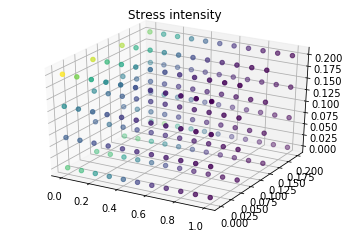

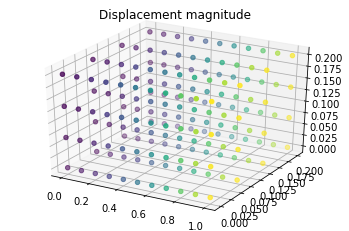

In [28]:
#from fenics import *
from ufl import nabla_div

# Scaled variables
L = 1; W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
#plt.figure() 
#plot(u, title='Displacement', mode='displacement')

# Save solution
file_out = File("displacement.pvd")
file_out << u

# Download results, open in Paraview
from google.colab import files
files.download("displacement.pvd")
files.download("displacement000000.vtu")

# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plt.figure() 
plot(von_Mises, title='Stress intensity')

# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)
plt.figure() 
plot(u_magnitude, title='Displacement magnitude')
print('min/max u:',
      u_magnitude.vector()[:].min(),
      u_magnitude.vector()[:].max())